#Getting data

In [1]:
# Connecting to your Google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Getting the drive content
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/BK_darbs")
!ls

BK_work.ipynb  Cases.csv  Estimates.csv


In [3]:
from numpy import nan_to_num
import pandas as pd

# Reding file "Estimates.CSV"
EstimatesDF = pd.read_csv('Estimates.csv',sep=';',decimal = '.', na_values = 0) 

# Reding file "Cases.CSV"
CasesDF = pd.read_csv('Cases.csv',sep=';',decimal = '.', na_values = 0) 

# Getting some initial statistics of the data set
print("\nDescription of EstimatesDF \n",EstimatesDF.describe())

# Getting some initial statistics of the data set
print("\nCases of EstimatesDF \n",CasesDF.describe())


Description of EstimatesDF 
          Time_std   Cost_std    Cost_DB     Time_DB    Cost_CM     Time_CM
count   32.000000  15.000000  24.000000   25.000000  16.000000   30.000000
mean    56.468750   6.666667   4.041667   36.520000   5.812500   50.833333
std    151.801225  19.754445  11.954549   84.674435  17.135611  135.904146
min      1.000000   1.000000   1.000000    1.000000   1.000000    1.000000
25%      1.000000   1.000000   1.000000    1.000000   1.000000    1.000000
50%      3.000000   1.000000   1.000000    3.000000   1.000000    3.000000
75%     21.000000   3.000000   2.000000   10.000000   2.250000   21.000000
max    520.000000  78.000000  60.000000  260.000000  70.000000  520.000000

Cases of EstimatesDF 
              Num    A1    A2    A3    A4    A5    A6    B1    B2    B3  ...  \
count  78.000000  26.0  26.0  26.0  78.0  78.0  78.0  78.0  39.0  39.0  ...   
mean   39.500000   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   
std    22.660538   0.0   0.0   0.0

# Genetic optimization

In [4]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 6.2 MB/s eta 0:00:00


In [5]:
import deap
import random
import operator
import numpy as np

from deap import base
from deap import creator
from deap import tools
from deap import gp

import math

### Fitnesa funkcija


Funkcijas radīšanai tiek izmantots universāls DEAP klašu konstruktors, kas izmanto:

*   bāzes klasi *base.Fitness*
*   jaunās klases nosaukumu *FitnessMin_square*
*   mērķu sarakstu - arī vienkāršas mērķa funkcijas gadījumā izmanto  mērķu sarakstu, lai klase būtu universāla. 

Šajā piemērā mērķa funkcija ir vienkārša minimizēšanas funkcija vienam argumentam.

Ja ir salikts mēŗkis, piemēram [x1,x2,x3], tad *Fitnesa* funkcija var iekļaut katra mērķa funkcijas argumenta optimizācijas nosačijumus, piemēram, (-1.0, -1.0, 1.0). Piemērā, pirmās divas mērķa komponentes tiek minimizētas, bet trešā maksimizēta. 

In [6]:
creator.create("FitnessMin_square", base.Fitness, weights=(-1.0,))

### Indivīdi


Indivīda strktūra un kodējums ir atkarīgs no konkrēta uzdevuma, piemēram, ģenētiskās programmēšanas gadījumā, tas ir koks, vinekāršas parametru optimizācijas gadījumā, tas ir saraksts ar reāliem skaitļiem, utml...

Visiem iespējamiem uzdevumu tipiem dotā pakotne nenodrošina indivīda kodējumu, bet tipiskiem gan:


*   Reālu skaitļu saraksts
*   Permutācijas tips
*   Aritmētiska izteiksme - ģ.programmēšanas gadījumiem
*   Evolūcijas stratēģijas tips - nodrošina sareģžģītkas mutācijas iespējas
*   Daļiņa (*Particle*) - īpāsu uzdevumu tips, kam piemīt ātrums un tā soēj atcerēties tās kabāko pozīciju. 

Šajā piemērā tiks izmantots saraksts ar vienu vienīgu reālu skaitli.

In [7]:
creator.create("Individual", list, fitness=creator.FitnessMin_square)

IND_SIZE=1

maxcases = CasesDF.shape[0]

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, maxcases-1)
toolbox.register("individual", tools.initRepeat, creator.Individual,toolbox.attr_int, n=IND_SIZE)

In [8]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

POP_SIZE = 10

toolbox.population(n=POP_SIZE)

[[64], [58], [59], [64], [34], [55], [64], [64], [21], [58]]

In [9]:
# ==== Evaluation operators, that calsulates the possible time and cost impact on the case implemented

def evaluateOneMin(individual):
    Case = CasesDF[CasesDF['Num'] == individual[0]]
    Case = Case.fillna(0)
    Case.reset_index()
    CaseClean = Case.iloc[:,2:]
    kind = Case.iloc[0,1]

    time = 0.0
    cost = 0.0

    wt = 1.0
    wc = 1.0

    for key, value in CaseClean.iteritems():
        estimates = EstimatesDF[EstimatesDF['Nr'] == key]
        estimates = estimates.fillna(0)
        if(kind == 'standard'):
          time = time + float(estimates['Time_std'])*float(value)
          cost = cost + float(estimates['Cost_std'])*float(value)
          #print(float(value))
        elif (kind == 'CM'):
          time = time + float(estimates['Time_CM'])*float(value)
          cost = cost + float(estimates['Cost_CM'])*float(value)
        elif (kind == 'DB'):
          time = time + float(estimates['Time_DB'])*float(value)
          cost = cost + float(estimates['Cost_DB'])*float(value)

    y = wt*time + wc*cost
    #print(y)

    #if(y == 0.0):
      #print(kind, CaseClean)
    
    return y,

toolbox.register("evaluate", evaluateOneMin)

In [10]:
# ==== Testing the evaluation operator on randomly generated individual

from logging import exception
ind1 = toolbox.individual()
try:
  ind1.fitness.values = evaluateOneMin(ind1) 
except:
  print(ind1)
print(ind1)
print(ind1.fitness.valid)    
print(ind1.fitness)     

[60]
True
(2072.0,)


In [11]:
# ==== Mutation operator, that simply selects another option from the list of possible - generates a new case
def mymutation(individual):
  ind = toolbox.individual()
  ind.fitness.values = evaluateOneMin(ind)
  return ind,

toolbox.register("mutate", mymutation)

In [12]:
# ==== crossover operator, that simply selects the best individual, since we have limited number of allowed cases

def myCorssover(individual1, individual2):
    val1 = evaluateOneMin(individual1)
    val2 = evaluateOneMin(individual2)
    if(val1 > val2):
        return(individual1,individual1)
    else:
        return(individual2,individual2)

toolbox.register("mate", myCorssover)

In [13]:
# ==== Selection as tournament

toolbox.register("select", tools.selTournament, tournsize=3)

In [14]:
import array
import numpy
from deap import algorithms

pop = toolbox.population(n=100)  # setting the population size
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [15]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.005, ngen=10, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min	max 
0  	100   	2131.51	560.361	940	2911
1  	48    	1806.51	432.193	940	2621
2  	48    	1522.68	357.477	940	2029
3  	54    	1266.75	318.092	940	1799
4  	42    	1090.83	303.31 	940	2868
5  	53    	964.71 	139.068	940	2336
6  	53    	953.82 	137.507	940	2322
7  	53    	970.89 	217.09 	940	2621
8  	55    	968.04 	212.135	940	2911
9  	62    	940    	0      	940	940 
10 	48    	940    	0      	940	940 


In [16]:
print("The best individual = ", hof.items[0])

The best individual =  [53]


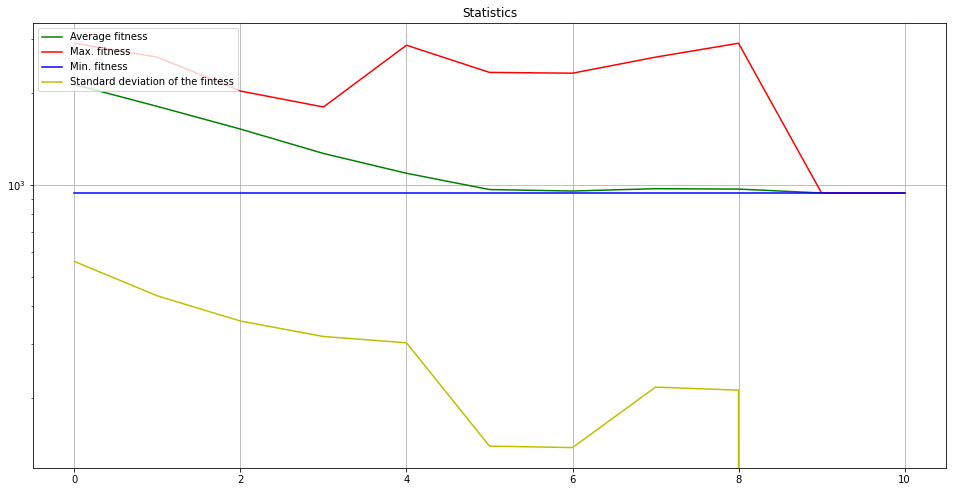

In [17]:
import matplotlib.pyplot as plt

x = list(range(0,11))
avg, max_, min_, std_ = log.select("avg", "max", "min", "std")

plt.figure(figsize=(36,18))
plt.subplot(2, 2, 1)
plt.semilogy(x, avg, "-g", label="Average fitness")
plt.semilogy(x, max_, "r", label="Max. fitness")
plt.semilogy(x, min_, "b", label="Min. fitness")
plt.semilogy(x, std_, "y", label="Standard deviation of the fintess")
plt.legend(loc="upper left")
plt.grid(True)
plt.title("Statistics")


plt.show()